In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 9})
%config InlineBackend.figure_format = 'svg'

In [3]:
def reduce_mem_usage(train_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = train_df.memory_usage().sum() / 10242
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_df.columns:
        col_type = train_df[col].dtype

        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        else:
            train_df[col] = train_df[col].astype('category')

    end_mem = train_df.memory_usage().sum() / 10242
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_df

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    plt.subplot(122)
    sns.set_palette("rocket_r",n_colors=2)
    
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.legend(['Train','Test'])

    plt.show()

## Загружаем данные из CSV

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Оптимизируем данные, для ускорения работы и уменьшения потребления памяти

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH,index_col='Id')
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 156.22 MB
Memory usage after optimization is: 55.69 MB
Decreased by 64.4%


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH,index_col='Id')
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 74.20 MB
Memory usage after optimization is: 24.93 MB
Decreased by 66.4%


### Визуализируем данные

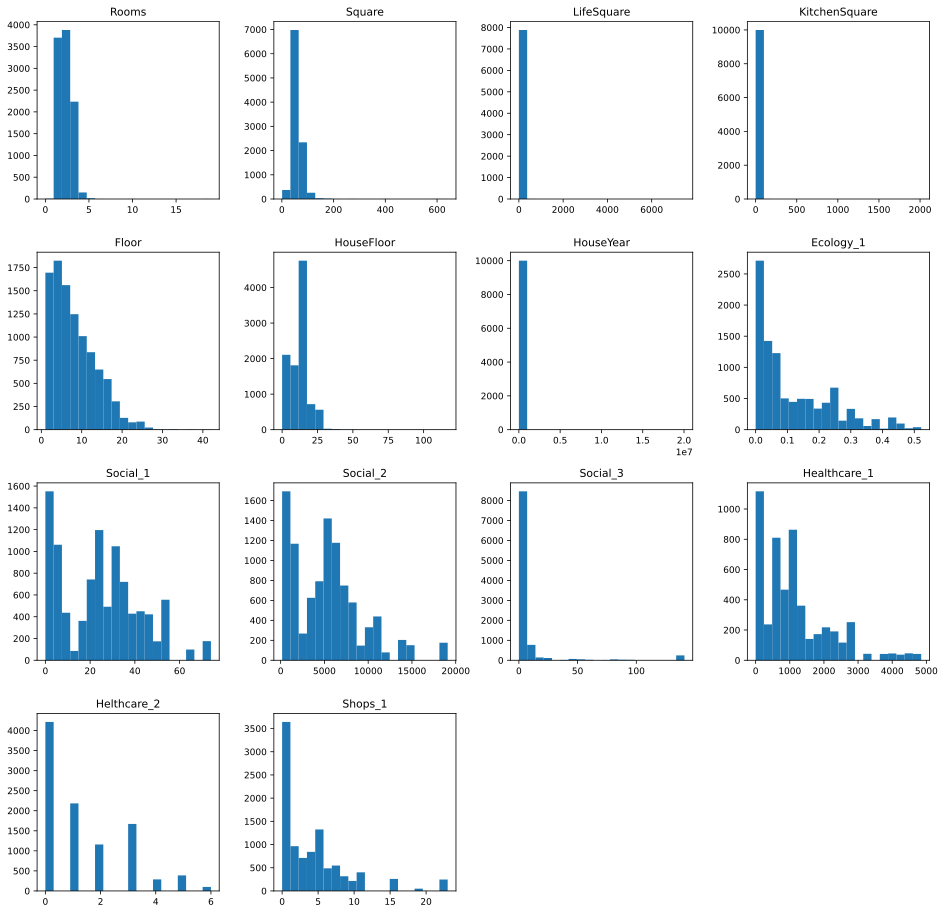

In [8]:
train_df.select_dtypes(include=['int8', 'int16', 'int32', 'float32']).drop(['Price', 'DistrictId'], axis=1, inplace=False).hist(figsize=(16,16), bins=20, grid=False);


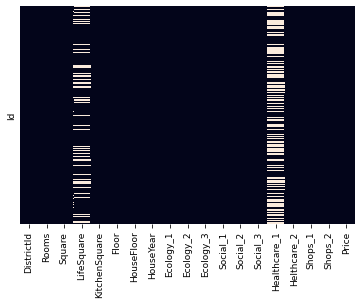

In [9]:
%config InlineBackend.figure_format = 'png'
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False);

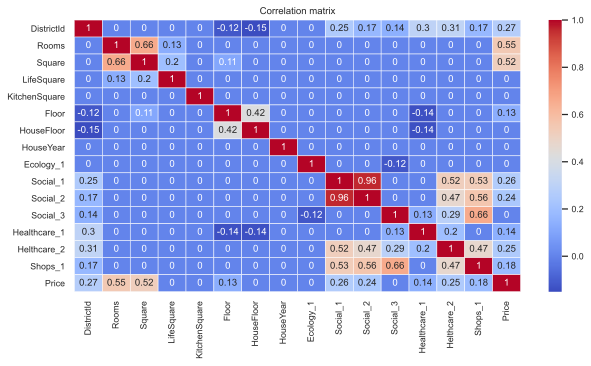

In [10]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (10,5))

sns.set(font_scale=0.8)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Интерпритируя визуализацию можем сделать вывод что [Rooms,Square,LifeSquare,KitchenSqare,HouseFloor,HouseYear] имеют вылеты в данных, и [LifeSquere,HealthCare_1] имеют много пропусков.

## Чистим данные от выбросов

In [11]:
def preprocess(df):
    df.HouseYear[df.HouseYear >= datetime.now().year] = datetime.now().year
    df['HouseFloor'][df['HouseFloor'] >= 60]=df['HouseFloor'].median()
    df['LifeSquare'][df['LifeSquare'] >= df['LifeSquare'].quantile(0.99)] = df['LifeSquare'].median()
    df['Square'][df['Square'] >= df['Square'].quantile(0.99)] = df['Square'].median()
    df['KitchenSquare'][df['KitchenSquare'] >= df['KitchenSquare'].quantile(0.99)] = df['KitchenSquare'].median()
    df['Square'][df['Square'] >= df['Square'].quantile(0.99)] = df['Square'].median()

    return df

In [12]:
train_df=preprocess(train_df)
test_df=preprocess(test_df)

Синтезируем значения для заполнения вылетов для Квадратных метров и Комнат.

In [13]:
def SynthSquare(train_df_ls):
    rfr_model = RandomForestRegressor()
    train_df_ls = train_df_ls[['LifeSquare','Square','KitchenSquare','Rooms']].copy()
    train_df_ls= train_df_ls[train_df_ls['LifeSquare'] < train_df_ls['LifeSquare'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['Square'] < train_df_ls['Square'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['KitchenSquare'] < train_df_ls['KitchenSquare'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['Rooms'] < train_df_ls['Rooms'].quantile(0.95)]
    train_df_ls.dropna(inplace=True)

    Xs = train_df_ls.drop(['LifeSquare'], axis=1, inplace=False)
    ys = train_df_ls['LifeSquare']
    rfr_model.fit(Xs, ys)
    ys_train_preds = rfr_model.predict(Xs)
    r = r2(ys, ys_train_preds)
    print(r)
    Xs = train_df[['Square','KitchenSquare','Rooms']]
    ys = train_df['LifeSquare']

    rfr_LS= rfr_model.predict(Xs)
    train_df['LifeSquare_SYNT'] = rfr_LS
    train_df['LifeSquare_SYNT']=train_df['LifeSquare_SYNT'].values.astype(np.float32)
    train_df['LifeSquare'][train_df['LifeSquare']< train_df['Square']]=train_df['LifeSquare_SYNT']
    train_df['LifeSquare'][train_df['LifeSquare'] == train_df['LifeSquare'].clip(0,10,inplace=False)] = train_df['LifeSquare_SYNT']
    train_df['LifeSquare'].fillna(train_df['LifeSquare_SYNT'], inplace=True)

    train_df.drop(['LifeSquare_SYNT'], axis=1, inplace=True)

    return train_df

In [14]:
train_df=SynthSquare(train_df)
test_df=SynthSquare(test_df)

0.8856374249020521
0.9104319447736383


Синтезируем значения для заполнения выбросов по комнатам.

In [15]:
def SynthRooms(train_df_ls):
    rfr_model = RandomForestRegressor()
    train_df_ls = train_df_ls[['LifeSquare','Square','KitchenSquare','Rooms']].copy()
    train_df_ls= train_df_ls[train_df_ls['LifeSquare'] < train_df_ls['LifeSquare'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['Square'] < train_df_ls['Square'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['KitchenSquare'] < train_df_ls['KitchenSquare'].quantile(0.95)]
    train_df_ls= train_df_ls[train_df_ls['Rooms'] < train_df_ls['Rooms'].quantile(0.95)]
    train_df_ls.dropna(inplace=True)


    Xs = train_df_ls.drop(['Rooms'], axis=1, inplace=False)
    ys = train_df_ls['Rooms']
    rfr_model.fit(Xs, ys)
    ys_train_preds = rfr_model.predict(Xs)
    r = r2(ys, ys_train_preds)
    print(r)
    Xs = train_df[['LifeSquare','Square','KitchenSquare']]
    ys = train_df['Rooms']

    rfr_LS= rfr_model.predict(Xs)
    train_df['Rooms_SYNT'] = rfr_LS
    train_df['Rooms_SYNT']=train_df['Rooms_SYNT'].values.astype(np.float32)
    train_df['Rooms'][train_df.Rooms >= 6] =train_df['Rooms_SYNT']
    train_df.drop(['Rooms_SYNT'], axis=1, inplace=True)

    return train_df

In [16]:
train_df=SynthRooms(train_df)
test_df=SynthRooms(test_df)

0.983762436441872
0.9836526702718681


Отображаем пробелы признаке Healthcare_1, забегая вперед решаем избавится от признака в целом.

In [17]:
train_df[train_df['Healthcare_1'].isna() == True]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,52.513039,39.006027,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
2352,1,1.0,40.409908,41.764812,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
13866,94,2.0,64.285065,40.408451,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
9951,1,1.0,46.887894,42.862358,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
16755,88,2.0,53.975143,31.812702,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9289,1,3.0,84.486076,88.931511,0.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.562500
1260,61,2.0,49.090729,30.566076,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
16265,27,2.0,64.307686,40.457684,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250


In [18]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

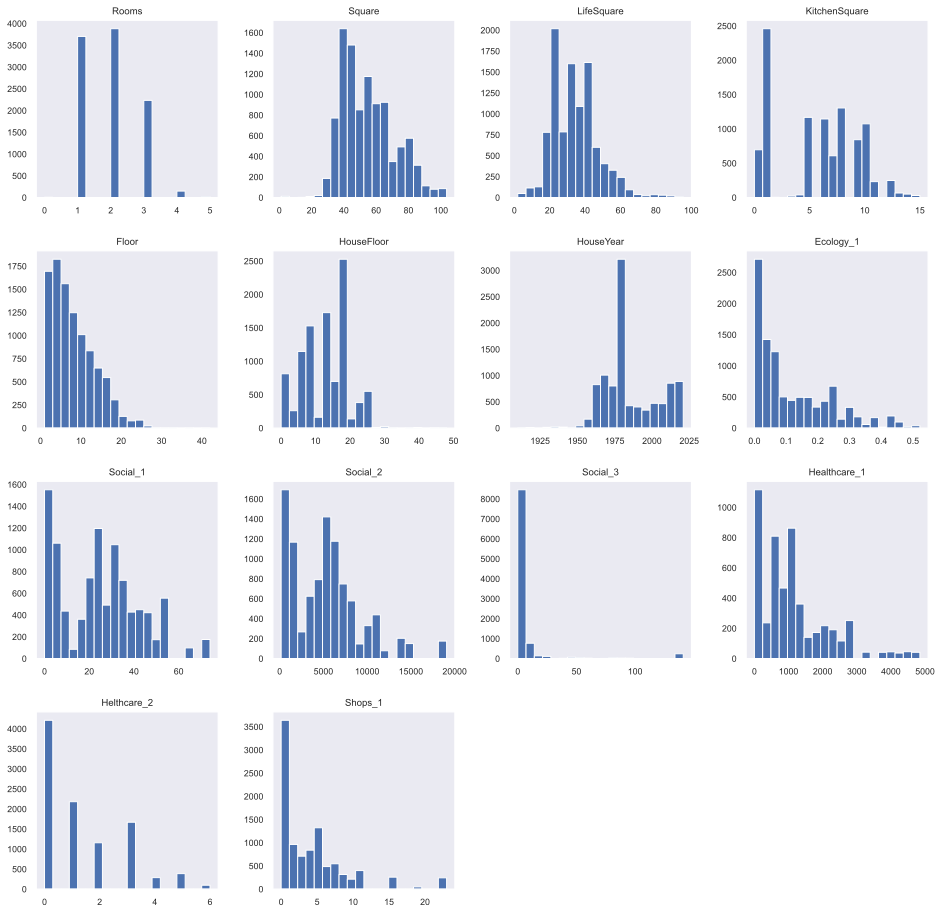

In [19]:
train_df.select_dtypes(include=['int8', 'int16', 'int32', 'float32']).drop(['Price', 'DistrictId'], axis=1, inplace=False).hist(figsize=(16,16), bins=20, grid=False);


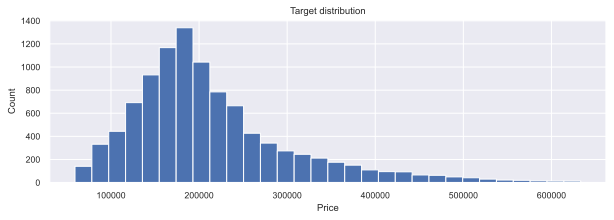

In [20]:
plt.figure(figsize = (10,3))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## Добавляем фичи

Добавляем фичи такие как размер района, и меняем признак экологии с буквеных на числовые значения.

In [21]:
def district_new_fet(train_df):
    district_size = train_df['DistrictId'].value_counts().reset_index()\
                        .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    train_df = train_df.merge(district_size, on='DistrictId', how='left')
    return train_df

In [22]:
train_df=district_new_fet(train_df)
test_df=district_new_fet(test_df)

In [23]:
def ecology_fix(train_df):
    binary_to_numbers = {'A': 0, 'B': 1}
    train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
    train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
    train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)
    return train_df

In [24]:
train_df=ecology_fix(train_df)
test_df=ecology_fix(test_df)

## Создание модели

Создаем список не важных фичей, также забегая вперед, оценивая по функции feature_importances. Приводим фичи в одинаковый маштаб стандартным scaler`ом. Строим модель случайного леса, получаем слегка переобученую модель. 

In [25]:
Unimportant_list=["Price","Healthcare_1","Ecology_2","Shops_2","Ecology_3"]

In [26]:
X = train_df.drop(Unimportant_list,axis=1,inplace=False)
y = train_df["Price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=21)

In [27]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)


Train R2:	0.862
Test R2:	0.738


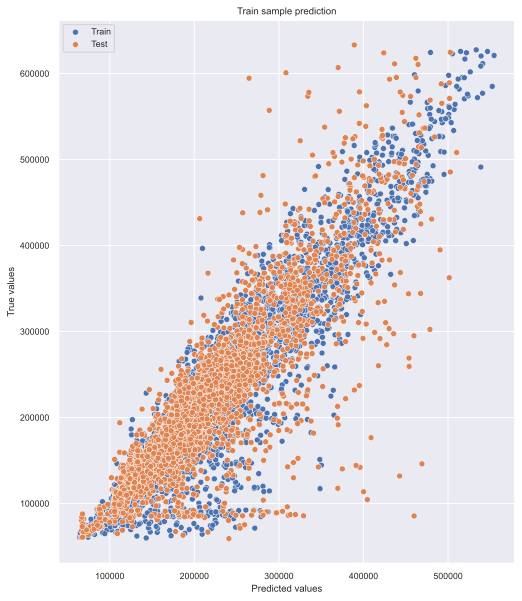

In [28]:
rf_model = RandomForestRegressor( n_estimators=500,max_depth=10, random_state=42, criterion='mse',n_jobs=16)
rf_model.fit(X_train_scaled, y_train)
y_train_preds = rf_model.predict(X_train_scaled)
y_test_preds = rf_model.predict(X_test_scaled)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [29]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

fi= feature_importances.sort_values(by='importance', ascending=False,ignore_index=True)

print(fi)

     feature_name  importance
0          Square    0.280956
1           Rooms    0.228873
2    DistrictSize    0.200061
3        Social_3    0.054538
4       HouseYear    0.032199
5      LifeSquare    0.031680
6       Ecology_1    0.030208
7      DistrictId    0.023322
8        Social_2    0.022932
9           Floor    0.021204
10     HouseFloor    0.020874
11       Social_1    0.019352
12  KitchenSquare    0.015619
13        Shops_1    0.013285
14    Helthcare_2    0.004897


Применяем модель на валидационый датасет

In [30]:
Xtest = test_df.drop(Unimportant_list,axis=1,inplace=False)
Xtest_scaled = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)
y_test_preds = rf_model.predict(Xtest_scaled)

print(y_test_preds)



[227434.0230155  175610.24824175 257773.22750138 ... 160179.21069797
 152472.32405942 158067.56477367]


In [31]:
pred_df = pd.DataFrame()
pred_df['Id'] = test_df.index
pred_df['Price'] = y_test_preds
pred_df.set_index("Id",inplace=True,drop=True)
pred_df.to_csv("predictions.csv")